In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=3

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=3


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import omegaconf
import numpy as np
import matplotlib.pyplot as plt
from ganime.data.base import load_dataset
from ganime.data.kny import KNYImage
from ganime.utils.statistics import dataset_statistics
from ganime.model.vqgan_clean.vqgan import VQGAN
from ganime.visualization.videos import display_images, display_videos
from ganime.model.vqgan_clean.transformer.mingpt import GPT
import tensorflow as tf
from datetime import datetime
from tqdm import tqdm
from pyprojroot.pyprojroot import here
#tf.get_logger().setLevel('ERROR')

In [37]:
gpt = GPT(vocab_size=4096,
        block_size=512,
        n_layer=12,
        n_head=12,
        n_embedding=768,
        embedding_percentage_drop=0.1,
        attention_percentage_drop=0.1)

In [38]:
input = tf.keras.layers.Input((512))
h = input
for block in gpt.layers:
    h = block(h)
tf.keras.Model(inputs=input, outputs=h).summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 512)]             0         
                                                                 
 token_and_position_embeddin  (None, 512, 768)         3538944   
 g_8 (TokenAndPositionEmbedd                                     
 ing)                                                            
                                                                 
 transformer_block_36 (Trans  (None, 512, 768)         33065472  
 formerBlock)                                                    
                                                                 
 transformer_block_37 (Trans  (None, 512, 768)         33065472  
 formerBlock)                                                    
                                                                 
 transformer_block_38 (Trans  (None, 512, 768)         3306

In [34]:
input = tf.keras.layers.Input((512))
h = input
for block in gpt.layers:
    h = block(h)
tf.keras.Model(inputs=input, outputs=h).summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 512)]             0         
                                                                 
 token_and_position_embeddin  (None, 512, 768)         3538944   
 g_6 (TokenAndPositionEmbedd                                     
 ing)                                                            
                                                                 
 transformer_block_v2_48 (Tr  (None, 512, 768)         33065472  
 ansformerBlockV2)                                               
                                                                 
 transformer_block_v2_49 (Tr  (None, 512, 768)         33065472  
 ansformerBlockV2)                                               
                                                                 
 transformer_block_v2_50 (Tr  (None, 512, 768)         3306

In [20]:
tf.keras.Model(inputs=gpt.layers[0], outputs=gpt.layers[-1])

ValueError: Found unexpected instance while processing input tensors for keras functional model. Expecting KerasTensor which is from tf.keras.Input() or output from keras layer call(). Got: <ganime.model.vqgan_clean.transformer.mingpt.TokenAndPositionEmbedding object at 0x7f62a058e220>

In [17]:
gpt.build((None, 512))
gpt.summary()

Model: "gpt_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 token_and_position_embeddin  multiple                 3538944   
 g_2 (TokenAndPositionEmbedd                                     
 ing)                                                            
                                                                 
 transformer_block_v2 (Trans  multiple                 33065472  
 formerBlockV2)                                                  
                                                                 
 transformer_block_v2_1 (Tra  multiple                 33065472  
 nsformerBlockV2)                                                
                                                                 
 transformer_block_v2_2 (Tra  multiple                 33065472  
 nsformerBlockV2)                                                
                                                             

In [4]:
for device in tf.config.list_physical_devices("GPU"):
    tf.config.experimental.set_memory_growth(device, True)

In [5]:
num_workers = len(tf.config.list_physical_devices("GPU"))
batch_size = 128

In [6]:
cfg = omegaconf.OmegaConf.load(here("configs/default.yaml"))

In [12]:
logdir = "../../../logs/ganime/" + datetime.now().strftime("%Y%m%d-%H%M%S")
# Define the basic TensorBoard callback.
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [13]:
#train_ds, test_ds, input_shape = load_dataset("kny_images", "../../../data", batch_size=128)

In [41]:
train_ds = KNYImage("../../../data", batch_size=batch_size, split="train")

In [42]:
test_ds = KNYImage("../../../data", batch_size=batch_size, split="test")

In [17]:

import io
def plot_to_image(figure):
    """Converts the matplotlib plot specified by 'figure' to a PNG image and
    returns it. The supplied figure is closed and inaccessible after this call."""
    # Save the plot to a PNG in memory.
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    # Closing the figure prevents it from being displayed directly inside
    # the notebook.
    plt.close(figure)
    buf.seek(0)
    # Convert PNG buffer to TF image
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    # Add the batch dimension
    image = tf.expand_dims(image, 0)
    return image

class TensorBoardImage(tf.keras.callbacks.Callback):

    def __init__(self, logdir, train, validation=None):
        super(TensorBoardImage, self).__init__()
        self.logdir = logdir
        self.train = train
        self.validation = validation
        self.file_writer = tf.summary.create_file_writer(logdir)

    def on_epoch_end(self, epoch, logs):
        train_imgs = self.train[0][0]
        val_imgs = self.validation[0][0][:10]

        train_pred = self.model.predict(train_imgs)
        validation_pred = self.model.predict(val_imgs)

        with self.file_writer.as_default():
            tf.summary.image("Training data", plot_to_image(display_images(train_pred)), step=epoch)
            tf.summary.image("Validation data", plot_to_image(display_images(validation_pred)), step=epoch)

tensorboard_image_callback = TensorBoardImage(logdir=logdir, train=train_ds, validation=test_ds)

2022-05-23 07:40:38.029668: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-23 07:40:40.868204: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14252 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:01:00.0, compute capability: 8.6
2022-05-23 07:40:40.869275: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14252 MB memory:  -> device: 1, name: NVIDIA RTX A4000, pci bus id: 0000:25:00.0, compute capability: 8.6
2022-05-23 07:40:40.870155: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:2 w

In [18]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3', '/job:localhost/replica:0/task:0/device:GPU:4', '/job:localhost/replica:0/task:0/device:GPU:5', '/job:localhost/replica:0/task:0/device:GPU:6', '/job:localhost/replica:0/task:0/device:GPU:7')


In [21]:
train_mean, train_var, train_std = dataset_statistics(train_ds)

  0%|          | 0/227 [00:00<?, ?it/s]

In [51]:
from ganime.visualization.images import display_true_pred

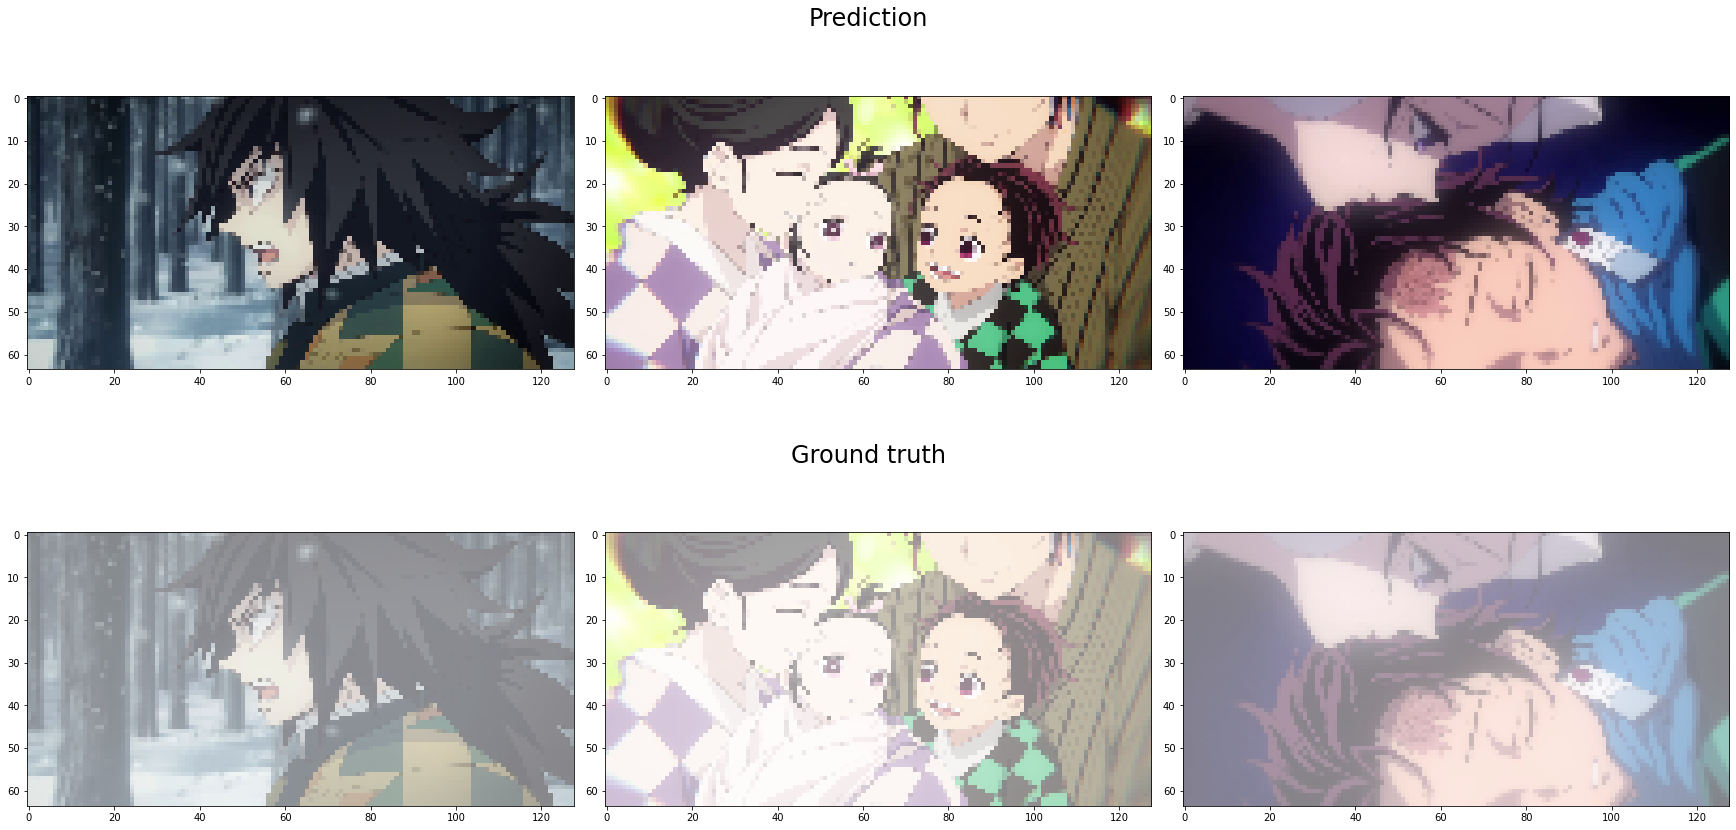

In [81]:
display_true_pred(train_ds.get_fixed_batch(100)[1], train_ds.get_fixed_batch(100)[0])
plt.show()

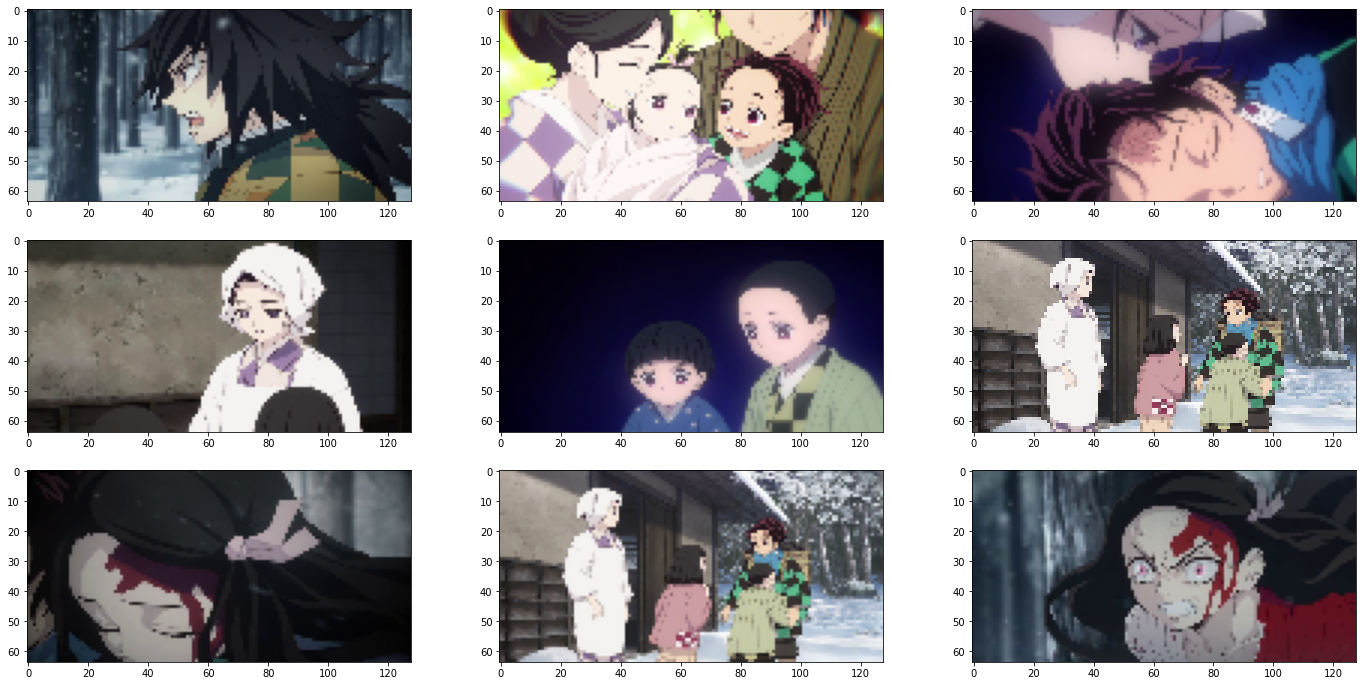

In [50]:
display_images(train_ds.get_fixed_item(100)[0])
plt.show()

In [21]:
#with strategy.scope():
#    vqgan = VQGAN(num_embeddings=128, embedding_dim=128, train_variance=train_var, disc_iter_start=len(train_ds) * 0)

In [31]:
cfg["model"]

{'vqvae_config': {'beta': 0.25, 'num_embeddings': 128, 'embedding_dim': 128}, 'autoencoder_config': {'z_channels': 128, 'channels': 128, 'channels_multiplier': [1, 1, 2, 2], 'num_res_blocks': 2, 'attention_resolution': [16], 'resolution': 128, 'dropout': 0.0}, 'discriminator_config': {'num_layers': 3, 'filters': 64}, 'loss_config': {'discriminator': {'loss': 'hinge', 'factor': 1.0, 'start': 10000, 'weight': 0.3}, 'vqvae': {'codebook_weight': 1.0}}}

In [36]:
with strategy.scope():
    vqgan = VQGAN(train_variance=train_var, **cfg["model"])

Working with z of shape (1, 128, 16, 16) = 32768 dimensions.
VQLPIPSWithDiscriminator running with hinge loss.


In [37]:
with strategy.scope():
    vqgan.compile(gen_optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4), disc_optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5))
history = vqgan.fit(train_ds, epochs=10)

2022-05-23 07:47:25.373941: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_112088"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021FlatMapDataset:62"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          size: 

Epoch 1/10
INFO:tensorflow:batch_all_reduce: 275 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 13 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 275 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 13 all-reduces with algorithm = nccl, num_packs = 1
227/227 [==============================] - 615s 784ms/step - total_loss: 16.3563 - reconstruction_loss: 9.6379 - vq_loss: 6.7184 - disc_loss: 0.0000e+00
Epoch 2/10
227/227 [==============================] - 107s 472ms/step - total_loss: 14.2006 - reconstruction_loss: 7.7473 - vq_loss: 6.4533 - disc_loss: 0.0000e+00
Epoch 3/10
227/227 [==============================] - 107s 472ms/step - total_loss: 23.9568 - reconstruction_loss: 6.5112 - vq_loss: 17.4456 - disc_loss: 0.0000e+00
Epoch 4/10
227/227 [==============================] - 107s 472ms/step - total_loss: 19.9071 - reconstruction_loss: 5.4189 - vq_loss: 14.4882 - disc_loss: 0.0000e

In [18]:
#history = vqgan.fit(train_ds, epochs=30, steps_per_epoch=5, callbacks=[tensorboard_callback, tensorboard_image_callback])

In [38]:
x = train_ds[100][0]
generated = vqgan(x[:10])

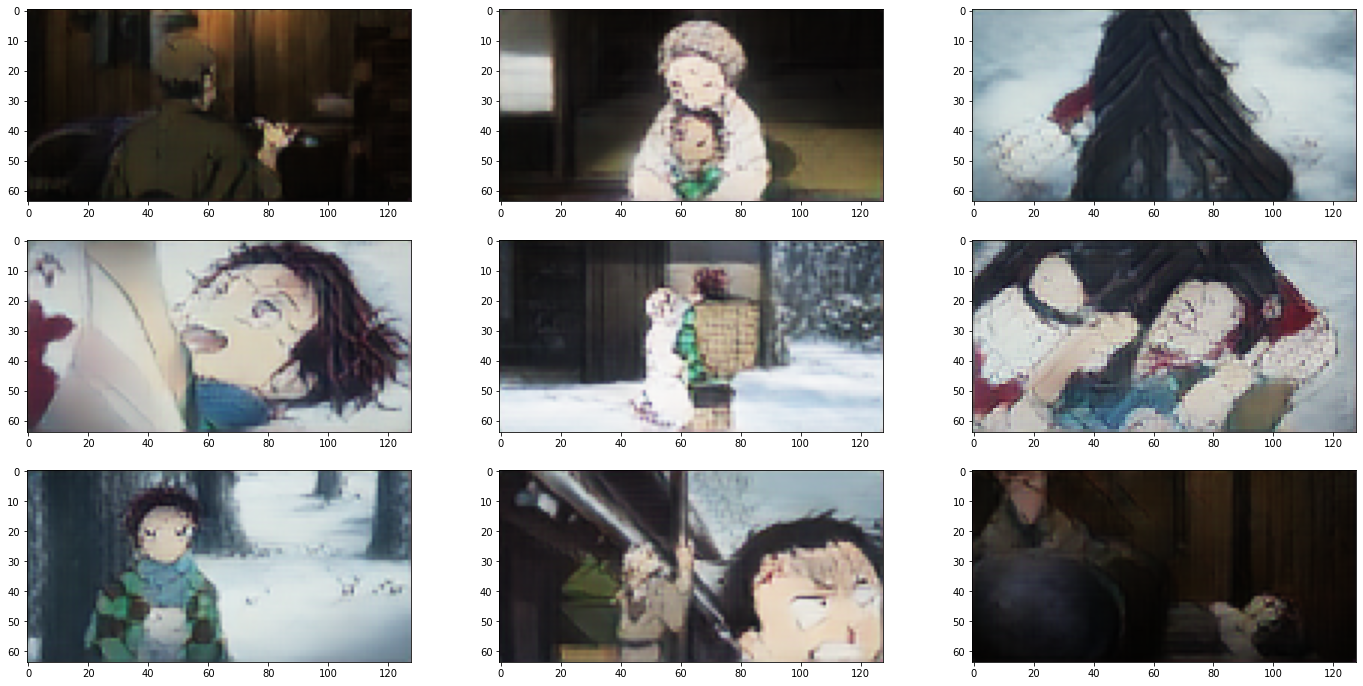

In [39]:
display_images(generated)
plt.show()

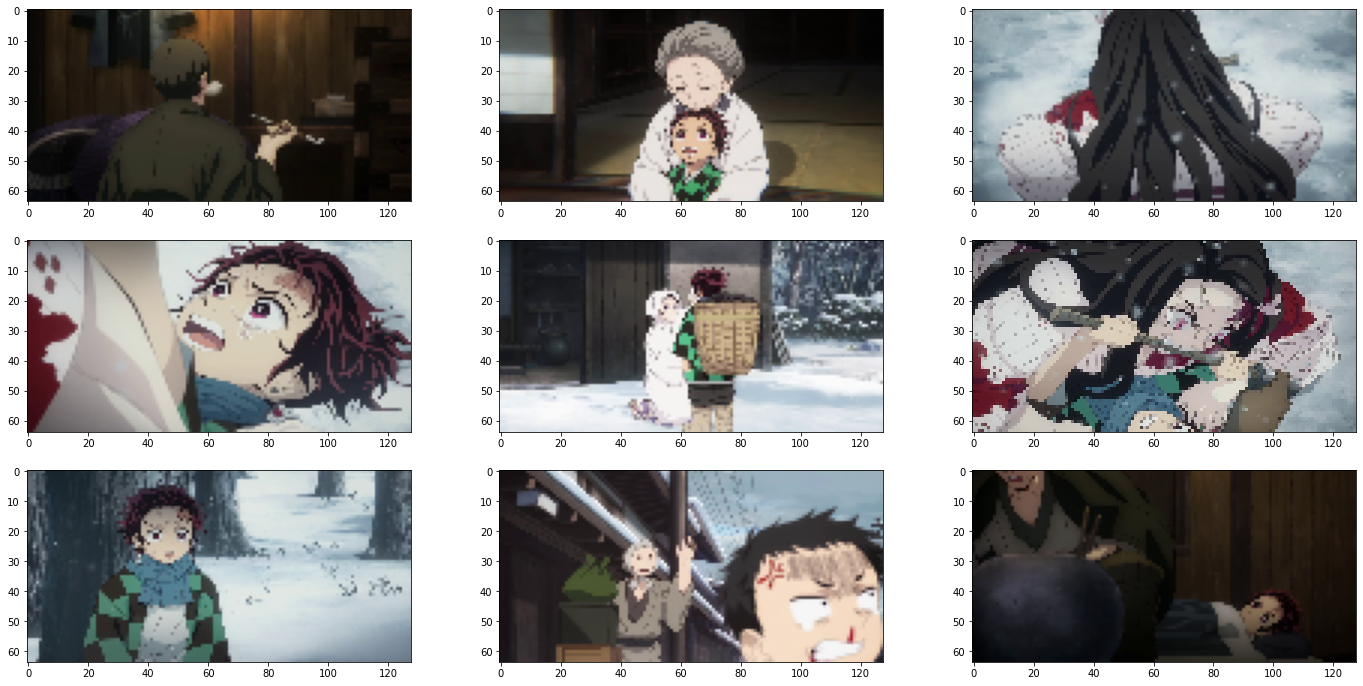

In [40]:
display_images(x)
plt.show()

In [52]:
x2 = train_ds[30][0]
generated2 = vqgan(x2[:10])

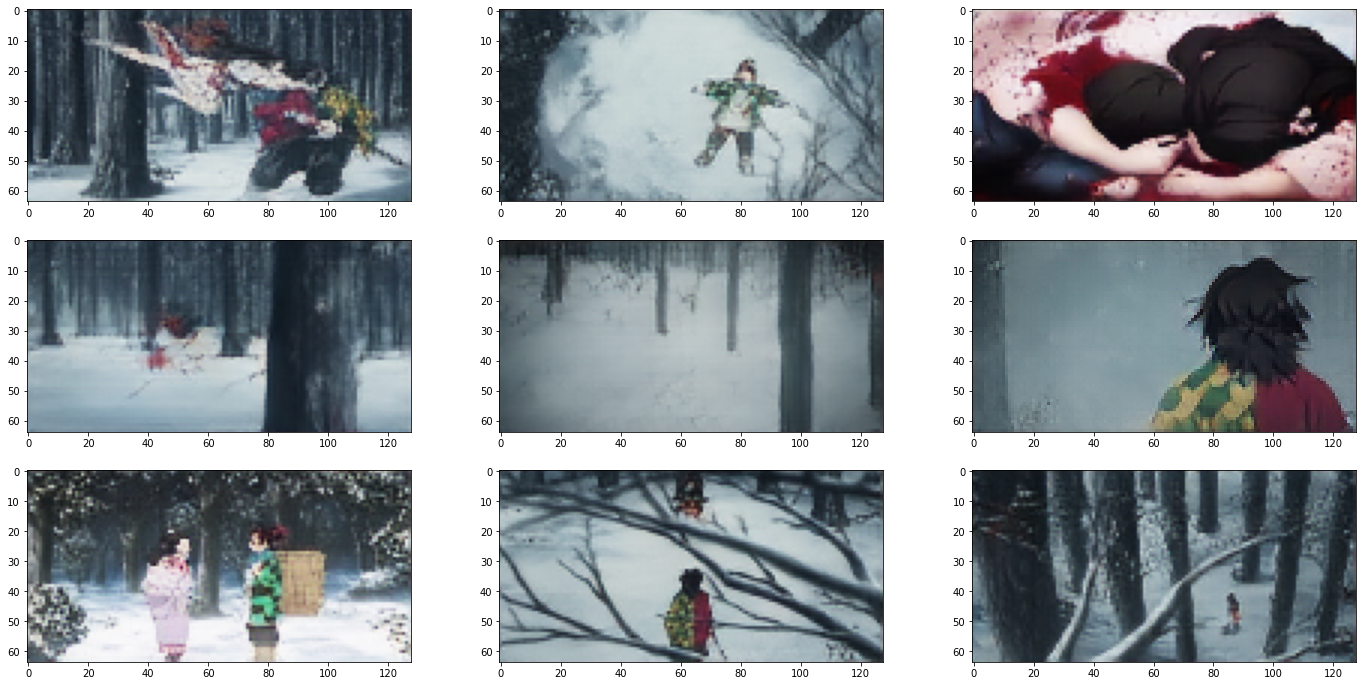

In [53]:
display_images(generated2)
plt.show()

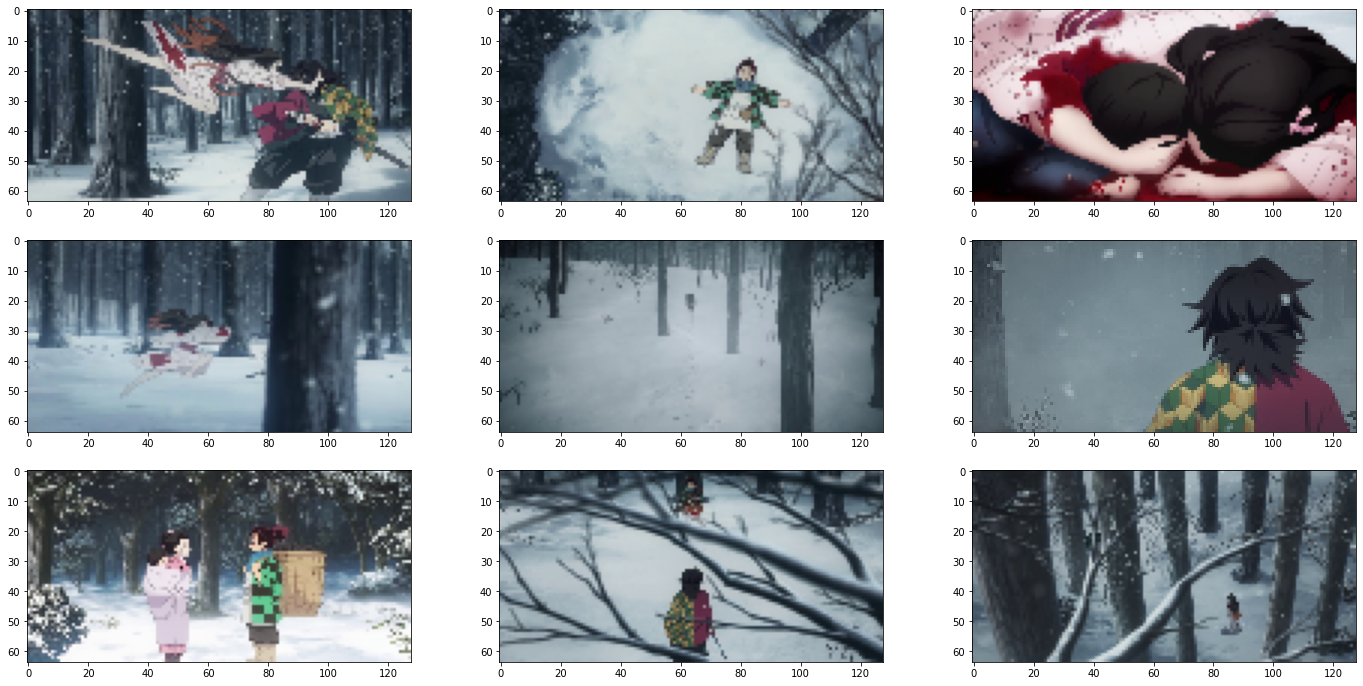

In [54]:
display_images(x2)
plt.show()

In [35]:
vqgan.save("../../../models/kny_discriminator_64x128")

INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ee23129d100>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ee23129d100>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ee193f75e50>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ee193f75e50>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ee18d734070>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ee18d734070>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ee072ef0250>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ee072ef0250>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ee070df1370>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ee070df1370>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edf025ad550>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edf025ad550>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edebbd66730>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edebbd66730>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ef425c6bbb0>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ef425c6bbb0>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edeb8d8a640>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edeb8d8a640>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edeb8c17130>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edeb8c17130>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edeb89d2940>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edeb89d2940>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edeb886ba60>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edeb886ba60>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edea9f1d2e0>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edea9f1d2e0>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edea9d09a90>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edea9d09a90>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edea9b7c400>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edea9b7c400>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edea99699d0>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edea99699d0>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ee23129d100>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ee23129d100>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ee193f75e50>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ee193f75e50>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ee18d734070>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ee18d734070>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ee072ef0250>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ee072ef0250>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ee070df1370>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ee070df1370>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edf025ad550>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edf025ad550>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edebbd66730>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edebbd66730>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ef425c6bbb0>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ef425c6bbb0>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edeb8d8a640>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edeb8d8a640>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edeb8c17130>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edeb8c17130>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edeb89d2940>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edeb89d2940>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edeb886ba60>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edeb886ba60>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edea9f1d2e0>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edea9f1d2e0>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edea9d09a90>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edea9d09a90>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edea9b7c400>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edea9b7c400>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edea99699d0>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edea99699d0>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ee23129d100>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ee23129d100>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ee193f75e50>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ee193f75e50>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ee18d734070>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ee18d734070>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ee072ef0250>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ee072ef0250>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ee070df1370>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ee070df1370>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edf025ad550>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edf025ad550>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edebbd66730>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edebbd66730>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ef425c6bbb0>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ef425c6bbb0>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edeb8d8a640>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edeb8d8a640>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edeb8c17130>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edeb8c17130>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edeb89d2940>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edeb89d2940>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edeb886ba60>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edeb886ba60>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edea9f1d2e0>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edea9f1d2e0>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edea9d09a90>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edea9d09a90>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edea9b7c400>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edea9b7c400>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edea99699d0>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edea99699d0>, 17025, 0.0), {}).


INFO:tensorflow:Assets written to: ../../../models/kny_discriminator_64x128/assets


INFO:tensorflow:Assets written to: ../../../models/kny_discriminator_64x128/assets
